#                                    Project: Wrangle and Analyze Data

## Introduction

The dataset to be wrangled below is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a 
Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. But the numerators are almost always greater than 10. 11/10, 12/10, 13/10, etc. Because "they're good dogs Brent." 
WeRateDogs has over 4 million followers and has received international media coverage.

Using Python and its libraries, data has been gathered from a variety of sources and in a variety of formats, assessed for its 
quality and tidiness, then cleaned. This is called data wrangling. I have documented my wrangling efforts in this Jupyter notebook
and performed analysis and visualizations using Python (and its libraries).



## Gather

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import urllib
import tweepy
import csv
import json
import time
from functools import reduce
import re


In [2]:
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response


<Response [200]>

In [3]:
#response.content

In [4]:
with open('image_predictions.tsv', 'wb') as handle:
    for block in response.iter_content(1024):
        handle.write(block)
        

In [5]:
breed_predict_df = pd.read_csv('image_predictions.tsv', sep = '\t')


In [6]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv', sep = ',')

In [7]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#Use tweepy.OAuthHandler to create an authentication using the given key and secret
auth = tweepy.OAuthHandler('bhXrEpRjdc7RGdnCi6J64iAJF', 'JYxaqvx2h9c2KTyyNO9XYTzeV4yBqdnNDrHZrNgWgUIQ0DZsXn')

#Connect to the Twitter API using the authentication/create API object to gather data
api = tweepy.API(auth)


#querying the Twitter API for each tweet's JSON data using Python's Tweepy library
missing_tweets = []
with open("tweet_json.txt", "w", encoding = 'utf-8') as file:  
    for tweet_id in archive_df['tweet_id']:
        try:
            tweet = api.get_status(id = tweet_id, tweet_mode='extended',wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
            json.dump(tweet._json, file)
            file.write('\n')
#        except tweepy.RateLimitError:
#            time.sleep(15*60)
        except tweepy.TweepError: 
            missing_tweets.append(tweet_id)
print (len(missing_tweets))           


#checking for thr number of tweets copied into the text file
with open('tweet_json.txt') as f:
        for i, l in enumerate(f):
            pass
print (i + 1)


In [8]:
#code to import the json objects from the .txt file into a dataframe:
#read .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

df=pd.read_json('tweet_json.txt', lines=True)


In [9]:
df.head(1)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",38696,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,NaN,NaN,NaN,NaN,8558,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [10]:
#copying the retweet_count, favorite_count columns from df to a new dataframe counts_df.
columns = ['tweet_id','retweet_count','fav_count']
counts_df = pd.DataFrame(columns=columns)

for tweet_id in archive_df['tweet_id']:
    counts_df['tweet_id'] = df['id']
    counts_df['retweet_count'] = df['retweet_count']
    counts_df['fav_count'] = df['favorite_count']



We are now ready with the three required dataframes.
1. breed_predict_df
2. archive_df
3. counts_df

## Assess

### Visual Assessment

In [11]:
archive_df.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2319,666447344410484738,NaN,NaN,2015-11-17 02:46:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. She is a black Downton Abbey. I...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666447344...,9,10,Scout,None,None,None,None
2119,670417414769758208,NaN,NaN,2015-11-28 01:42:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Sharp dog here. Introverted. Loves purple. Not...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670417414...,6,10,None,None,None,None,None
2224,668291999406125056,NaN,NaN,2015-11-22 04:56:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I can't do better than he did. 10/10 https://t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668291999...,10,10,None,None,None,None,None
559,803276597545603072,NaN,NaN,2016-11-28 16:37:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Winston. His selfie game is legendary....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/803276597...,11,10,Winston,None,None,None,None
1824,676496375194980353,NaN,NaN,2015-12-14 20:17:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Griffin. He's upset because his c...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676496375...,9,10,Griffin,None,None,None,None
351,831322785565769729,NaN,NaN,2017-02-14 02:02:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pete. He has no eyes. Needs a guide do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/831322785...,12,10,Pete,doggo,None,None,None
498,813130366689148928,8.131273e+17,4.196984e+09,2016-12-25 21:12:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've been informed by multiple sources that th...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
111,871032628920680449,NaN,NaN,2017-06-03 15:55:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Boomer. He's doing an advanced water t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/871032628...,13,10,Boomer,None,None,None,None
2072,671109016219725825,NaN,NaN,2015-11-29 23:30:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Toby. He asked for chocolate cake for ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671109016...,8,10,Toby,None,None,None,None
1782,677687604918272002,NaN,NaN,2015-12-18 03:11:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This was Cindy's face when she heard Susan for...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677687604...,11,10,None,None,None,None,None


In [12]:
counts_df.sample(20)

,tweet_id,retweet_count,fav_count
97,872967104147763200,5461,27406
2051,671163268581498880,1170,1719
1088,735991953473572864,1255,3836
691,786051337297522688,174,1567
1517,690348396616552449,558,1603
101,872486979161796608,9115,40769
168,858471635011153920,5064,22081
13,889638837579907072,4566,27114
203,852311364735569921,10583,34573
47,882992080364220416,3941,23899


In [13]:
breed_predict_df.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
248,670676092097810432,https://pbs.twimg.com/media/CU64WOlWcAA37TV.jpg,1,Dandie_Dinmont,0.676102,True,West_Highland_white_terrier,0.040826,True,clumber,0.039533,True
430,674269164442398721,https://pbs.twimg.com/media/CVt8OmIWIAAbxvJ.jpg,1,pug,0.622921,True,Norwegian_elkhound,0.048659,True,Cardigan,0.016966,True
1175,737445876994609152,https://pbs.twimg.com/media/CjvvHBwUoAE55WZ.jpg,1,Samoyed,0.400568,True,Pomeranian,0.331268,True,Maltese_dog,0.045426,True
713,685325112850124800,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True
572,678410210315247616,https://pbs.twimg.com/media/CWoyfMiWUAAmGdd.jpg,1,schipperke,0.145877,True,Labrador_retriever,0.098354,True,kelpie,0.097393,True
782,690005060500217858,https://pbs.twimg.com/media/CZNj8N-WQAMXASZ.jpg,1,Samoyed,0.270287,True,Great_Pyrenees,0.114027,True,teddy,0.072475,False
1258,748692773788876800,https://pbs.twimg.com/media/CmPkGhFXEAABO1n.jpg,1,ox,0.337871,False,plow,0.269287,False,oxcart,0.245653,False
1781,828708714936930305,https://pbs.twimg.com/media/C4AqLSgVYAEg8nt.jpg,1,hippopotamus,0.942911,False,Mexican_hairless,0.008388,True,ice_lolly,0.006206,False
657,682303737705140231,https://pbs.twimg.com/media/CXgHoLnWAAA8i52.jpg,1,seat_belt,0.997659,False,Lakeland_terrier,0.001731,True,Airedale,0.000204,True
889,699088579889332224,https://pbs.twimg.com/media/CbOpWswWEAE9kvX.jpg,1,mousetrap,0.456186,False,banded_gecko,0.258677,False,common_iguana,0.061783,False


### Programmatic assessment

In [14]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
archive_df[archive_df.in_reply_to_status_id.isnull() == False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [16]:
archive_df[archive_df.tweet_id.duplicated()]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [17]:
counts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id         2345 non-null int64
retweet_count    2345 non-null int64
fav_count        2345 non-null int64
dtypes: int64(3)
memory usage: 73.3 KB


In [18]:
counts_df.describe()

,tweet_id,retweet_count,fav_count
count,2.345000e+03,2345.000000,2345.000000
mean,7.422940e+17,3015.133475,8045.151812
std,6.833642e+16,5015.449077,12105.775761
min,6.660209e+17,0.000000,0.000000
25%,6.783802e+17,605.000000,1404.000000
50%,7.189392e+17,1405.000000,3529.000000
75%,7.986979e+17,3509.000000,9948.000000
max,8.924206e+17,77132.000000,143001.000000


In [19]:
counts_df[counts_df.tweet_id.duplicated()]

,tweet_id,retweet_count,fav_count


In [20]:
counts_df.tail()

,tweet_id,retweet_count,fav_count
2340,666049248165822465,41,109
2341,666044226329800704,141,299
2342,666033412701032449,45,125
2343,666029285002620928,47,129
2344,666020888022790149,517,2562


In [21]:
breed_predict_df.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [22]:
breed_predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
breed_predict_df[breed_predict_df.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


#### Quality

After both visual and programmatic assessment, the below quality issues were discovered.

##### archive_df table
- Records with non null values in 'retweeted_status_id' and 'retweeted_status_user_id'  and 'retweeted_status_user_id' columns     'in_reply_to_status_id' and 'in_reply_to_user_id' do not belong in the df.
- 'timestamp', 'expanded_urls' and 'source' columns not useful for analysis.
- Some of the values in rating columns are incorrect.
- Rating numerator in archive_df doesn't capture decimals.
- 'None', 'a', 'an', 'the', 'not', 'one' column values in the dog name column.
- Rating_numerator column must be a float as numerator in some ratings contain decimals. And 'tweet_id' column should be of       object type (i.e. strings), NOT integers or floats. 

##### breed_predict table
- Some of the images do not display dogs.
- p2 and p3 data, 'jpg_url' and 'img_num'  columns are not required for analysis.
- The columns with names 'p1', 'p1_dog' and 'p1_conf' should be more descriptive. 

## Clean


#### making copies of original dataframes on which the cleaning operations will be performed .

In [24]:

archive_df_clean = archive_df.copy()

In [25]:
breed_predict_df_clean = breed_predict_df.copy()

In [26]:
counts_df_clean = counts_df.copy()

### Quality

#### Define

##### archive_df
- Delete records with non null values in 'retweeted_status_id' and 'retweeted_status_user_id'  and 'retweeted_status_user_id'     in_reply_to_status_id' and 'in_reply_to_user_id' columns.
- Drop the above mentioned columns for remaining records, 'timestamp', 'expanded_urls' and 'source' columns.
- The 'name' column has values  'None', 'a', 'an', 'the', 'not', 'one' which need to be replaced by 'NA'.
- Correct the erroneous values in rating columns.
- Change Rating_numerator column data type to float.
- Change 'tweet_id' column type to object type (i.e. strings),

##### breed_predict 
- Drop columns containing Prediction2 and Prediction3 data and 'jpg_url', 'img_num' columns.
- Delete records having 'p1_dog' value False.
- Change column names 'p1', 'p1_dog' and 'p1_conf' to 'predicted_breed', 'dog_or_not', 'predict_confidence'


#### Code
Dropping the unrequired columns and rows to retain only the original tweets data and necessary columns.

In [27]:
# archive_df
archive_df_clean=archive_df[archive_df.retweeted_status_id.isnull() == True]


In [28]:
archive_df_clean=archive_df_clean[archive_df.in_reply_to_status_id.isnull() == True]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [29]:
#archive_df_clean.reset_index(drop=True, inplace=True)

In [30]:
archive_df_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_user_id','retweeted_status_timestamp'], axis=1, inplace=True)

In [31]:
del archive_df_clean['timestamp']

In [32]:
del archive_df_clean['expanded_urls']

In [33]:
del archive_df_clean['source']

In [34]:
del archive_df_clean['retweeted_status_id']

In [35]:
# breed_predict 
breed_predict_df_clean = breed_predict_df_clean[breed_predict_df.p1_dog == True]

In [36]:
#breed_predict_df_clean.reset_index(drop=True, inplace=True)

In [37]:
breed_predict_df_clean.drop(['p2','p2_conf','p2_dog','p3','p3_dog','p3_conf'], axis=1, inplace=True)

In [38]:
breed_predict_df_clean.drop(['jpg_url', 'img_num'], axis=1, inplace=True)

In [39]:
#replacing the anomalous dog names with NA
archive_df_clean['name'].replace(['very','the','a','an','None','not','one'],['NA','NA','NA','NA','NA','NA','NA'], inplace=True)


In [40]:
#change rating_numerator column data type to float.
archive_df_clean['rating_numerator'] = archive_df_clean.rating_numerator.astype(float)

In [41]:
#change 'tweet_id' column type to object type (i.e. strings)
archive_df_clean['tweet_id'] = archive_df_clean.tweet_id.apply(str)

In [42]:
#archive_df_clean['new_num'] = archive_df_clean['text'].str.extract(re.search(r"".astype(float)
# archive_df_clean['new_num'] = archive_df_clean['text'].str.extract(re.search(r"\d+(\.\d*)/$"))  
#re.search(r"\d+(\.\d*)/$")    
#archive_df_clean['new_num'] = archive_df_clean['text'].str.extract('[A-Za-z\.](\d+\.\d+)/$', expand=True)   
#archive_df_clean['new_num'] = archive_df_clean.text.str.extract(r'([0-9]+(\.)?([0-9])*)', expand=True) 
search = []    
for values in archive_df_clean['text']:
    search.append(re.search(r'([0-9]+(\.)?([0-9])*)', values).group())

archive_df_clean['clean_numerator'] = search


In [43]:
archive_df_clean['clean_numerator'] = archive_df_clean.clean_numerator.astype(float)

#### Test

In [44]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2097 non-null object
text                  2097 non-null object
rating_numerator      2097 non-null float64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
clean_numerator       2097 non-null float64
dtypes: float64(2), int64(1), object(7)
memory usage: 180.2+ KB


In [45]:
archive_df_clean.loc[archive_df_clean['name'] == 'Bella']
#clean_numerator values test

,tweet_id,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,clean_numerator
45,883482846933004288,This is Bella. She hopes her smile made you sm...,5.0,10,Bella,None,None,None,None,13.50
60,880465832366813184,This is Bella. She had her first beach experie...,12.0,10,Bella,None,None,None,None,12.00
1089,737800304142471168,This is Bella. She's ubering home after a few ...,10.0,10,Bella,None,None,None,None,10.00
1354,703631701117943808,This is Bella. Based on this picture she's at ...,11.0,10,Bella,None,None,None,None,8.00
1768,678389028614488064,This is Bella. She just learned that her final...,11.0,10,Bella,None,None,pupper,None,92.49
1964,673350198937153538,This is Bella. She's a Genghis Flopped Canuck....,9.0,10,Bella,None,None,None,None,9.00


In [46]:
breed_predict_df_clean.head(1)

,tweet_id,p1,p1_conf,p1_dog
0,666020888022790149,Welsh_springer_spaniel,0.465074,True


In [47]:
breed_predict_df_clean['tweet_id'] = breed_predict_df_clean.tweet_id.apply(str)
# make sure tweet_id in all 3 dfs are of same datatype 'str'

In [48]:
breed_predict_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 2073
Data columns (total 4 columns):
tweet_id    1532 non-null object
p1          1532 non-null object
p1_conf     1532 non-null float64
p1_dog      1532 non-null bool
dtypes: bool(1), float64(1), object(2)
memory usage: 49.4+ KB


In [49]:
counts_df_clean['tweet_id'] = counts_df_clean.tweet_id.apply(str)
# make sure tweet_id in all 3 dfs are of same datatype 'str'

In [50]:
counts_df_clean.head()

,tweet_id,retweet_count,fav_count
0,892420643555336193,8558,38696
1,892177421306343426,6292,33163
2,891815181378084864,4173,24964
3,891689557279858688,8690,42076
4,891327558926688256,9452,40228


In [51]:
counts_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id         2345 non-null object
retweet_count    2345 non-null int64
fav_count        2345 non-null int64
dtypes: int64(2), object(1)
memory usage: 73.3+ KB


#### Tidiness

##### Define
- Information about one type of observational unit (tweets) is spread across three different files/dataframes. So these three     dataframes should be merged.
- Dog stage data breaks the 'Each variable forms a column' tidy rule.


##### Code

In [52]:
#Merging all three dfs
dfs = [breed_predict_df_clean, counts_df_clean, archive_df_clean]
df_final = reduce(lambda left,right: pd.merge(left,right,on='tweet_id'), dfs )


In [53]:
df_final.head()

,tweet_id,p1,p1_conf,p1_dog,retweet_count,fav_count,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,clean_numerator
0,666020888022790149,Welsh_springer_spaniel,0.465074,True,517,2562,Here we have a Japanese Irish Setter. Lost eye...,8.0,10,NA,None,None,None,None,8.0
1,666029285002620928,redbone,0.506826,True,47,129,This is a western brown Mitsubishi terrier. Up...,7.0,10,NA,None,None,None,None,2.0
2,666033412701032449,German_shepherd,0.596461,True,45,125,Here is a very happy pup. Big fan of well-main...,9.0,10,NA,None,None,None,None,9.0
3,666044226329800704,Rhodesian_ridgeback,0.408143,True,141,299,This is a purebred Piers Morgan. Loves to Netf...,6.0,10,NA,None,None,None,None,6.0
4,666049248165822465,miniature_pinscher,0.560311,True,41,109,Here we have a 1949 1st generation vulpix. Enj...,5.0,10,NA,None,None,None,None,1949.0


In [54]:
#creating a new column 'dog_stage' from the already existing 4 columns using np.select 

conditions1 = [
    (df_final['doggo'] == 'None') & (df_final['floofer'] == 'None') & (df_final['pupper'] == 'None') & (df_final['puppo'] == 'None'),
    (df_final['doggo'] == 'doggo') & (df_final['floofer'] == 'None') & (df_final['pupper'] == 'None') & (df_final['puppo'] == 'None'),
    (df_final['doggo'] == 'None') & (df_final['floofer'] == 'floofer') & (df_final['pupper'] == 'None') & (df_final['puppo'] == 'None'),
    (df_final['doggo'] == 'None') & (df_final['floofer'] == 'None') & (df_final['pupper'] == 'pupper') & (df_final['puppo'] == 'None'),
    (df_final['doggo'] == 'None') & (df_final['floofer'] == 'None') & (df_final['pupper'] == 'None') & (df_final['puppo'] == 'puppo'),
    (df_final['doggo'] == 'doggo') & (df_final['floofer'] == 'floofer') & (df_final['pupper'] == 'None') & (df_final['puppo'] == 'None'),
    (df_final['doggo'] == 'doggo') & (df_final['floofer'] == 'None') & (df_final['pupper'] == 'pupper') & (df_final['puppo'] == 'None'),
    (df_final['doggo'] == 'doggo') & (df_final['floofer'] == 'None') & (df_final['pupper'] == 'None') & (df_final['puppo'] == 'puppo'),
    (df_final['doggo'] == 'None') & (df_final['floofer'] == 'floofer') & (df_final['pupper'] == 'None') & (df_final['puppo'] == 'puppo'),
    (df_final['doggo'] == 'None') & (df_final['floofer'] == 'floofer') & (df_final['pupper'] == 'pupper') & (df_final['puppo'] == 'None'),
    (df_final['doggo'] == 'None') & (df_final['floofer'] == 'None') & (df_final['pupper'] == 'pupper') & (df_final['puppo'] == 'puppo')]
choices1 = ['NA', 'doggo', 'floofer', 'pupper', 'puppo', 'doggo/floofer', 'doggo/pupper', 'doggo/puppo', 'floofer/puppo', 'floofer/pupper', 'pupper/puppo']
df_final['dog_stage'] = np.select(conditions1, choices1)



In [55]:
#dropping the original 4 columns of dog stages.
df_final.drop(['doggo', 'floofer', 'puppo', 'pupper'], axis=1, inplace=True)

##### Test 

In [56]:


df_final['name_islower'] = map(lambda x: x.islower(), df_final['name'])
# Because all abnormal dog names seem to begin with a lowercase letter. So making sure there are no more values in name column 
#beginning with lower case letter.

df_final.loc[df_final['name_islower'] == True] 



,tweet_id,p1,p1_conf,p1_dog,retweet_count,fav_count,text,rating_numerator,rating_denominator,name,clean_numerator,dog_stage,name_islower


In [57]:
del df_final['name_islower']

In [58]:
df_final.head(1)

,tweet_id,p1,p1_conf,p1_dog,retweet_count,fav_count,text,rating_numerator,rating_denominator,name,clean_numerator,dog_stage
0,666020888022790149,Welsh_springer_spaniel,0.465074,True,517,2562,Here we have a Japanese Irish Setter. Lost eye...,8.0,10,NA,8.0,NA


## Store

In [59]:
df_final.to_csv('twitter_archive_master.csv', header=True, sep=',', encoding='utf-8')

## Exploratory Data Analysis

In [60]:
#below csv file created after manual cleaning of few values in the rating_numerator and rating_denominator columns using ratings
#from the 'text' column.
df_final_edited = pd.read_csv('twitter_archive_master_edited.csv', sep=',')

In [61]:
df_final_edited.head(1)

,Unnamed: 0,tweet_id,p1,p1_conf,p1_dog,retweet_count,fav_count,text,rating_numerator,rating_denominator,name,dog_stage
0,0,6.660210e+17,Welsh_springer_spaniel,0.465074,True,518,2565,Here we have a Japanese Irish Setter. Lost eye...,8.0,10.0,NaN,NaN


In [62]:
df_final_edited['rating_denominator'].value_counts()


10.0     1453
50.0        2
80.0        2
150.0       1
70.0        1
90.0        1
40.0        1
110.0       1
Name: rating_denominator, dtype: int64

In [63]:
#df_final_10 contains tweets of rating_denominator value of 10
df_final_edited_10 = df_final_edited.loc[df_final['rating_denominator']==10]


In [64]:
df_final_edited['p1'].value_counts()


golden_retriever               137
Labrador_retriever              94
Pembroke                        88
Chihuahua                       78
pug                             54
chow                            41
Samoyed                         40
Pomeranian                      38
toy_poodle                      37
malamute                        29
cocker_spaniel                  27
French_bulldog                  26
Chesapeake_Bay_retriever        23
miniature_pinscher              21
Siberian_husky                  20
German_shepherd                 20
Staffordshire_bullterrier       19
Shetland_sheepdog               18
Maltese_dog                     18
Eskimo_dog                      18
Shih-Tzu                        17
Cardigan                        17
beagle                          17
Italian_greyhound               16
Rottweiler                      16
kuvasz                          15
Lakeland_terrier                15
West_Highland_white_terrier     14
Great_Pyrenees      

In [65]:
df_final_edited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463 entries, 0 to 1462
Data columns (total 12 columns):
Unnamed: 0            1463 non-null int64
tweet_id              1463 non-null float64
p1                    1463 non-null object
p1_conf               1463 non-null float64
p1_dog                1463 non-null bool
retweet_count         1463 non-null int64
fav_count             1463 non-null int64
text                  1463 non-null object
rating_numerator      1462 non-null float64
rating_denominator    1462 non-null float64
name                  1056 non-null object
dog_stage             227 non-null object
dtypes: bool(1), float64(4), int64(3), object(4)
memory usage: 127.2+ KB


In [66]:
df_final_edited.describe()

,Unnamed: 0,tweet_id,p1_conf,retweet_count,fav_count,rating_numerator,rating_denominator
count,1463.000000,1.463000e+03,1463.000000,1463.000000,1463.000000,1462.000000,1462.000000
mean,731.000000,7.408782e+17,0.615043,2734.430622,9219.553657,11.382353,10.430917
std,422.476035,6.860015e+16,0.260249,4754.817273,12871.864807,6.831664,6.035970
min,0.000000,6.660210e+17,0.044333,13.000000,80.000000,2.000000,10.000000
25%,365.500000,6.783065e+17,0.392933,634.000000,2174.500000,10.000000,10.000000
50%,731.000000,7.157330e+17,0.615741,1404.000000,4429.000000,11.000000,10.000000
75%,1096.500000,7.954320e+17,0.853345,3181.500000,11573.000000,12.000000,10.000000
max,1462.000000,8.921770e+17,0.999956,77202.000000,143127.000000,165.000000,150.000000


## Insights

Questions to be investigated in the analysis:
    1. What are the most popular breeds of dogs among pet owners? (analyse breed of dog 'p1' column)
    2. Analyse ratings. Why do some ratrings have different denominators other than 10?
    4. What factors influence retweet counts and favorite counts. text/image/ name/breed.
    

What are the most popular breeds of dogs among pet owners? (analyse breed of dog 'p1' column).
Here are the top 10 most popular breeds of dogs among pet owners.
1. golden_retriever
2. Labrador_retriever  
3. Pembroke  
4. Chihuahua
5. pug
6. chow
7. Samoyed
8. Pomeranian
9. toy_poodle
10.Malamute

Analyse ratings. Why do some ratings have different denominators other than 10?
Tweets with many dogs in the image are given ratings with higher denominators.

What factors influence retweet counts and favorite counts? text/image/ name/breed.
Tweets with interesting or emotional or funny stories/videos/ about the dog seem to result in higher retweet and favorite counts.
Tweets with normal looking and no special features seem to be given medium ratings, with ratings ranging from 2 to 14
for denominator 10.
On the other hand, tweets that use negative words to describe the dog or posts about anything other than a dog or have awkward/not very good loooking pictures
are given lowest ratings.

In [67]:
import matplotlib.pyplot as plt
% matplotlib inline

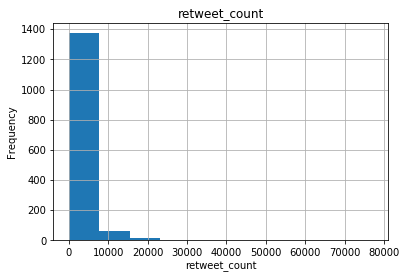

In [68]:
df_final.hist(column='retweet_count')
plt.xlabel("retweet_count")
plt.ylabel("Frequency")
plt.title('retweet_count');

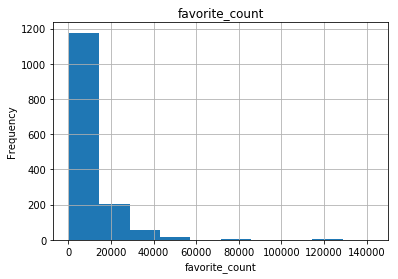

In [69]:
df_final.hist(column='fav_count')
plt.xlabel("favorite_count")
plt.ylabel("Frequency")
plt.title('favorite_count');


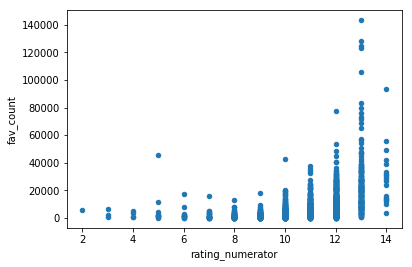

In [70]:

df_final_edited_10.plot(x='rating_numerator', y='fav_count', kind='scatter');

Analysis for above plot:
Most ratings are in the range of 2-14. In this plot, an exponential increase in fav_count with increase in rating_numerator can 
be observed with the curve ending at rating_numerator value of 14. 

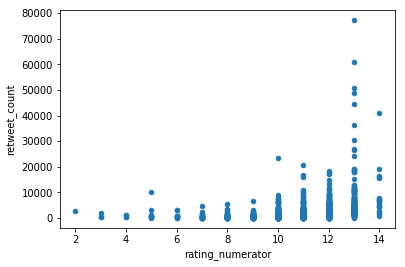

In [71]:
df_final_edited_10.plot(x='rating_numerator', y='retweet_count', kind='scatter');

Analysis for above plot:
Retweet count vs rating_numerator plot follows the same pattern as fav_count vs rating_numerator. But this plot is not as dense 
as the previous plot, especially at higher counts(counts above 20,000) on y axis.
This might be because, when we come across interesting posts/tweets, many of us hit the favorite icon rather than retweet.